In [6]:
import sys
sys.path.append('../src')
import mlflow
import os

from config_loader import load_config
from mlflow_setup import setup_mlflow
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import pymorphy3
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from datetime import datetime

Первый датасет

Загружаю конфиг из: ../config/dataset_1.yaml
Эксперимент установлен: metro_preprocessing
Размер исходного датасета: (31705, 8)
Первые 5 строк:
   message_id                                               text  \
0       13460  Московское метро (VK)\n\nКачество, стиль и пол...   
1       13453  Московское метро (VK)\n\n«А если мою биометрию...   
2       13452  Московское метро (VK)\n\nТеперь везде! Мы подк...   
3       13451  Квартиры в центре Мытищ в ипотеку от 35 170 ру...   
4       13446  Московское метро (VK)\n\nОсвещение в метро, ка...   

                  date  views  reactions  comments             channel_name  \
0  2025-12-11 13:01:51    345          0         0  Московский метрополитен   
1  2025-12-11 11:00:47    371          0         0  Московский метрополитен   
2  2025-12-11 06:36:17    526          0         0  Московский метрополитен   
3  2025-12-11 06:32:17    490          0         0  Московский метрополитен   
4  2025-12-10 13:09:59    685          0         0  М

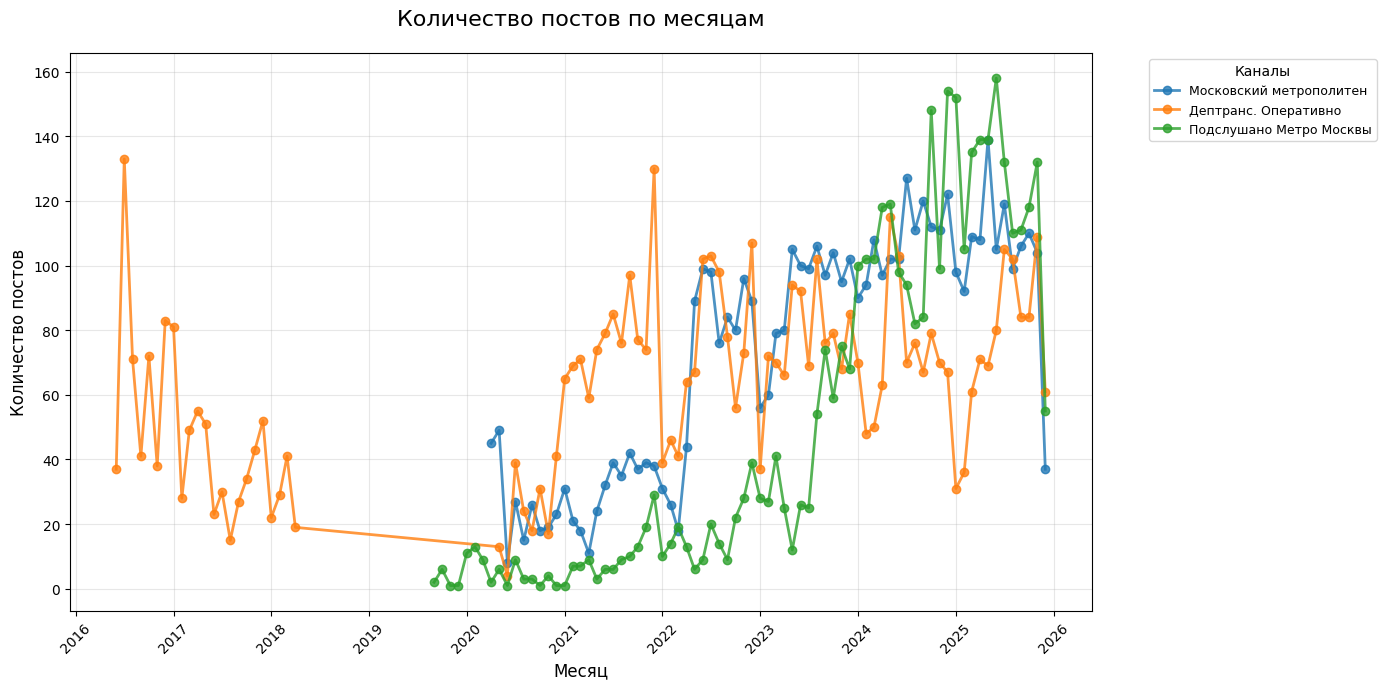

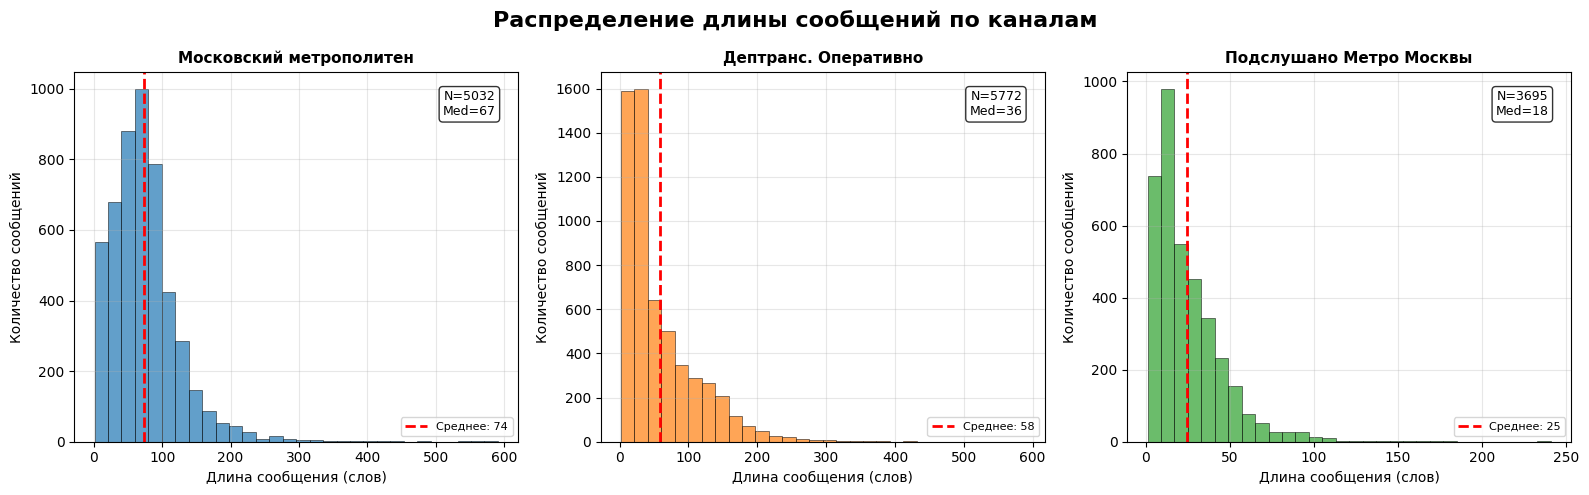

Фильтрация по длине сообщений (5-150 слов):
До фильтрации: 14499
После фильтрации: 13514
Удалено: 985


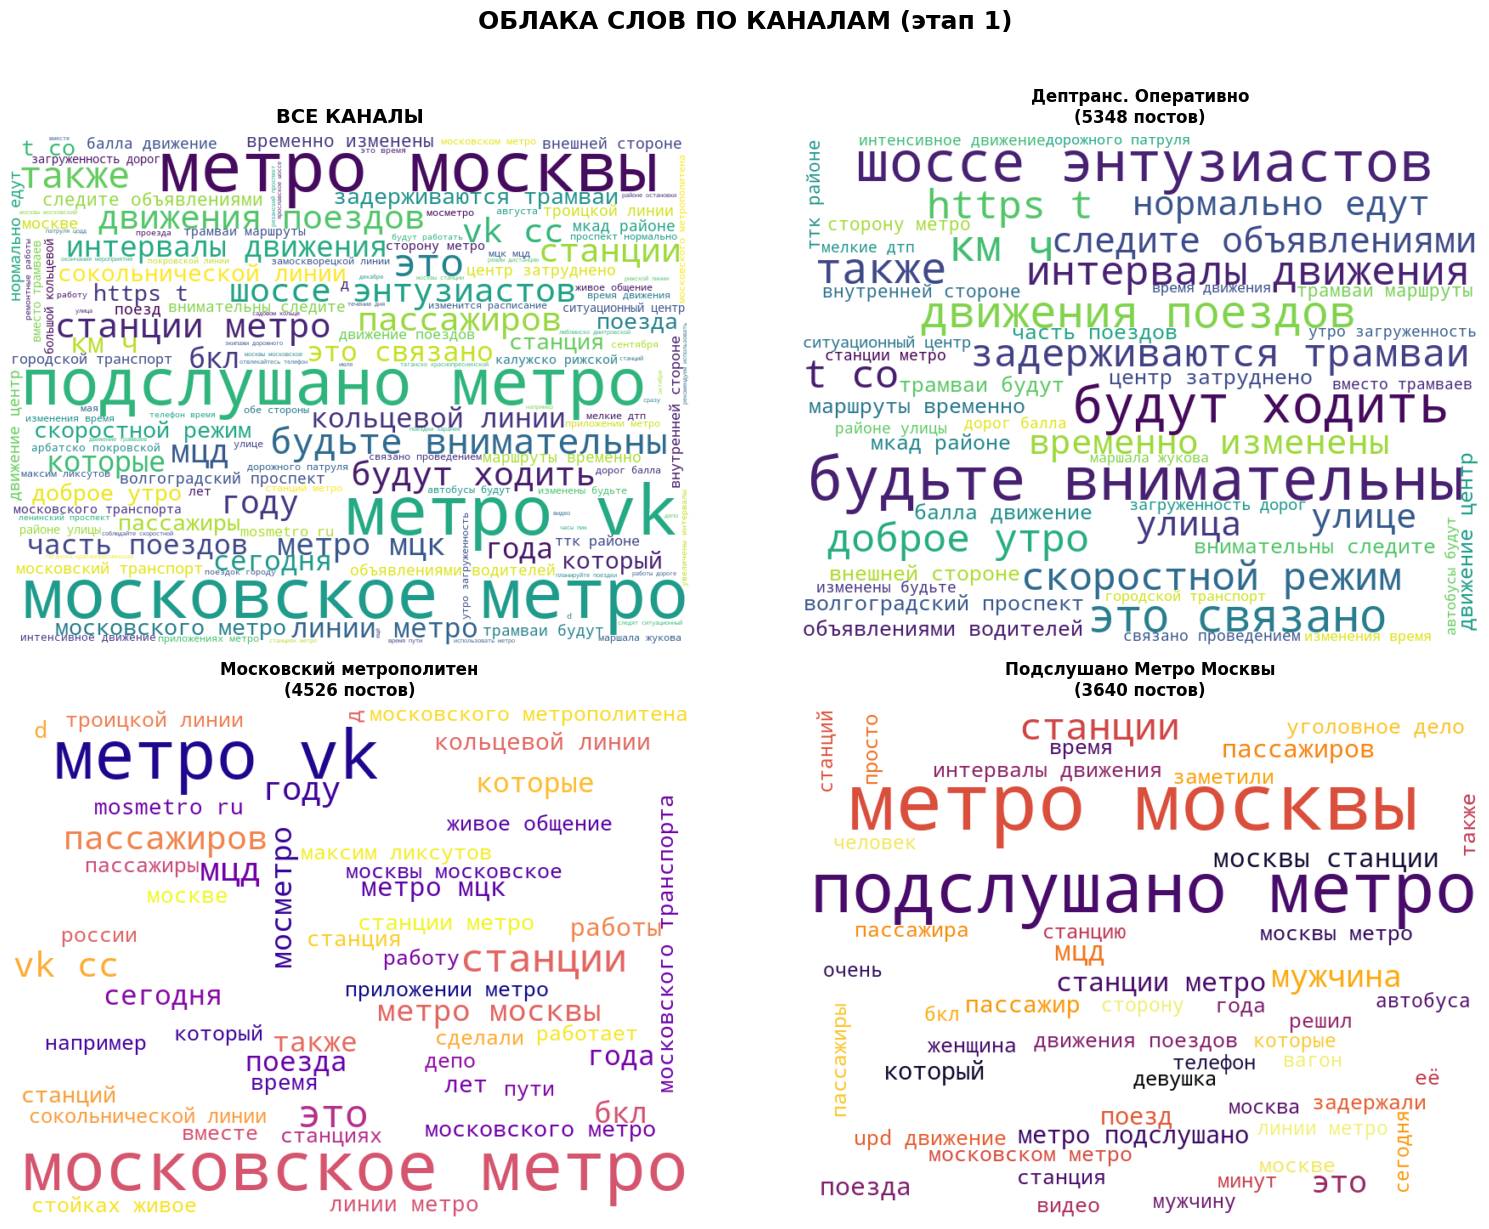


Результат этапа 1:
Финальный размер датасета: (12434, 4)

Первые 5 строк обработанных данных:
                          message_clean_no_stopwords                date  \
0  московское метро vk качество стиль польза это ... 2025-12-11 13:01:51   
1  московское метро vk мою биометрию украдут разв... 2025-12-11 11:00:47   
2  московское метро vk везде подключили биометрию... 2025-12-11 06:36:17   
3  квартиры центре мытищ ипотеку руб мес жк стран... 2025-12-11 06:32:17   
4  московское метро vk освещение метро часть архи... 2025-12-10 13:09:59   

              channel_name found_stations  
0  Московский метрополитен        [метро]  
1  Московский метрополитен        [метро]  
2  Московский метрополитен        [метро]  
3  Московский метрополитен         [вднх]  
4  Московский метрополитен        [метро]  
ЭТАП 2: Лемматизация


Обработка текстов (pymorphy3): 100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


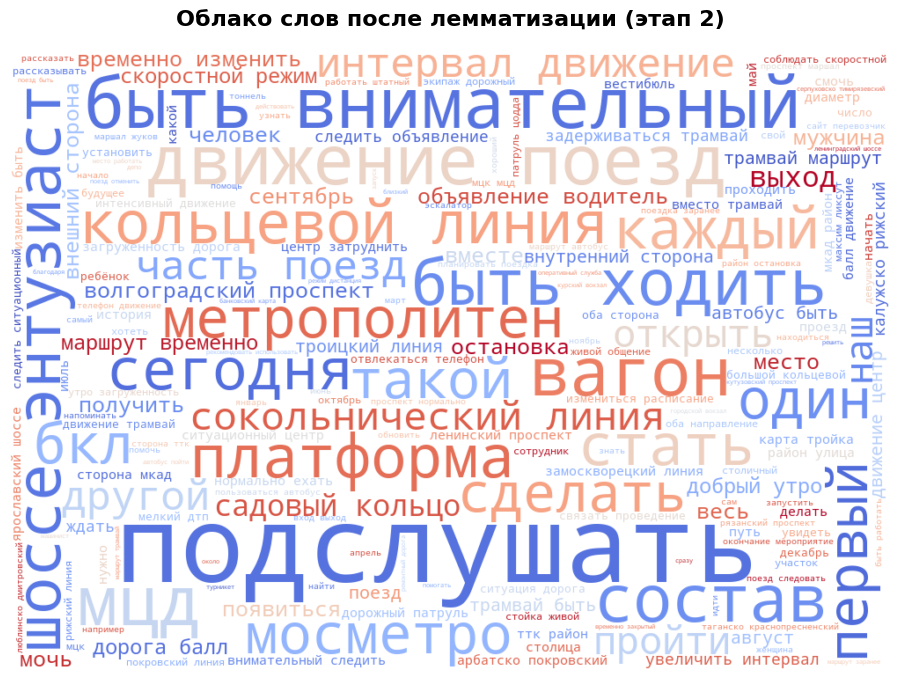


ОБЩАЯ СТАТИСТИКА ОБРАБОТКИ
Исходный датасет: (31705, 10)
После этапа 1: (12434, 4)
Финальный датасет: (12434, 5)

Сохраняем финальный результат в: ../data/data_processed2.csv
Обработка завершена
🏃 View run preprocessing_v2 at: http://127.0.0.1:8080/#/experiments/1/runs/3c6399714b1b45ef87ad3680044ea329
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [7]:
# Загружаем конфиг
cfg = load_config("dataset_1")

# Настройка MLflow
setup_mlflow(cfg)

# Старт run 
with mlflow.start_run(experiment_id=cfg['mlflow']['experiment_id'], run_name=cfg['mlflow']['run_name']) as run:

    # Логируем параметры препроцессинга
    mlflow.log_param("preprocessing.stage1.remove_emojis", True)
    mlflow.log_param("preprocessing.stage1.find_stations", True)
    mlflow.log_param("preprocessing.stage1.remove_stopwords", True)
    mlflow.log_param("preprocessing.stage2.library", "pymorphy3")
    mlflow.log_param("preprocessing.stage2.batch_processing", True)
    mlflow.log_param("preprocessing.stage2.custom_stopwords", True)
    
    # ========== ЭТАП 1: Базовый препроцессинг ==========
    
    # Загрузка данных с параметрами из конфига
    df = pd.read_csv(
        cfg['data']['input']['path'],
        sep=cfg['data']['input']['delimiter'],
        encoding=cfg['data']['input']['encoding'])
    
    # Получаем названия колонок из конфига
    text_column = cfg['data']['input']['columns']['text']
    
    print(f"Размер исходного датасета: {df.shape}")
    print(f"Первые 5 строк:")
    print(df.head(5))
    
    # Логирование исходных данных
    mlflow.log_artifact(cfg['data']['input']['path'], 'data')
    mlflow.log_metric("initial_rows", df.shape[0])
    mlflow.log_metric("initial_columns", df.shape[1])
    
    # Функция удаления эмодзи
    def remove_emojis(text):
        if isinstance(text, str):
            return emoji.replace_emoji(text, replace='')
        return text
    
    # Применяем удаление эмодзи
    df['message_clean'] = df[text_column].apply(remove_emojis)
    print(f"Эмодзи удалены. Колонка 'message_clean' создана.")
    
    # Поиск станций метро
    stations = cfg['preprocessing']['stations']
    
    def find_stations(text):
        found = []
        if isinstance(text, str):
            for station in stations:
                if station.lower() in text.lower():
                    found.append(station)
        return found if found else None
    
    # Применяем функцию к колонке
    df['found_stations'] = df['message_clean'].apply(find_stations)
    
    # Фильтруем строки, где найдены станции
    df_with_stations = df[df['found_stations'].notna()].copy()
    
    # Проверяем результаты
    print(f"Всего записей: {len(df)}")
    print(f"Записей со станциями: {len(df_with_stations)}")
    
    # Логируем статистику
    mlflow.log_metric("stage1_total_records", len(df))
    mlflow.log_metric("stage1_records_with_stations", len(df_with_stations))
    mlflow.log_metric("stage1_stations_ratio", 
                     len(df_with_stations) / len(df) if len(df) > 0 else 0)
    
    # Анализ по месяцам (график)
    if 'date' in df_with_stations.columns and 'channel_name' in df_with_stations.columns:
        plt.figure(figsize=(14, 7))
        
        # Преобразуем дату
        df_with_stations['date'] = pd.to_datetime(df_with_stations['date'])
        
        # Агрегируем по месяцам
        df_with_stations['month'] = df_with_stations['date'].dt.to_period('M').dt.start_time
        
        # Строим график для каждого канала
        for channel in df_with_stations['channel_name'].unique():
            channel_data = df_with_stations[df_with_stations['channel_name'] == channel].copy()
            monthly_counts = channel_data.groupby('month').size()
            
            plt.plot(monthly_counts.index, monthly_counts.values, 
                     marker='o', linewidth=2, 
                     label=channel, alpha=0.8)
        
        plt.title('Количество постов по месяцам', fontsize=16, pad=20)
        plt.xlabel('Месяц', fontsize=12)
        plt.ylabel('Количество постов', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Каналы', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Сохраняем и логируем график
        monthly_plot_path = "stage1_monthly_posts.png"
        plt.savefig(monthly_plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(monthly_plot_path, 'plots/stage1')
        plt.show()
    
    # Анализ длины сообщений
    df_with_stations['word_count'] = df_with_stations['message_clean'].apply(
        lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    if 'channel_name' in df_with_stations.columns:
        length_col = 'word_count'
        channels = df_with_stations['channel_name'].unique()
        
        fig, axes = plt.subplots(1, min(3, len(channels)), figsize=(16, 5))
        fig.suptitle('Распределение длины сообщений по каналам', fontsize=16, fontweight='bold')
        
        for idx, channel in enumerate(channels[:3]):
            if len(channels) == 1:
                ax = axes
            else:
                ax = axes[idx]
                
            channel_data = df_with_stations[df_with_stations['channel_name'] == channel]
            
            ax.hist(channel_data[length_col], 
                    bins=30, 
                    alpha=0.7, 
                    color=f'C{idx}', 
                    edgecolor='black', 
                    linewidth=0.5)
            
            mean_length = channel_data[length_col].mean()
            ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, 
                       label=f'Среднее: {mean_length:.0f}')
            
            ax.set_title(f'{channel}', fontsize=11, fontweight='bold')
            ax.set_xlabel('Длина сообщения (слов)')
            ax.set_ylabel('Количество сообщений')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            stats_text = f'N={len(channel_data)}\nMed={channel_data[length_col].median():.0f}'
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                    fontsize=9, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        length_plot_path = "stage1_message_length_distribution.png"
        plt.savefig(length_plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(length_plot_path, 'plots/stage1')
        plt.show()
    
    # Фильтрация по длине сообщений
    initial_count = len(df_with_stations)
    df_with_stations = df_with_stations[
        df_with_stations['message_clean'].apply(
            lambda x: 5 <= len(str(x).split()) <= 150)].copy()
    filtered_count = len(df_with_stations)
    
    print(f"Фильтрация по длине сообщений (5-150 слов):")
    print(f"До фильтрации: {initial_count}")
    print(f"После фильтрации: {filtered_count}")
    print(f"Удалено: {initial_count - filtered_count}")
    
    mlflow.log_metric("stage1_after_length_filter", filtered_count)
    
    # Удаление стоп-слов
    try:
        stop_words = set(stopwords.words('russian'))
    except LookupError:
        nltk.download('stopwords')
        stop_words = set(stopwords.words('russian'))
    
    def clean_text_from_stopwords(text):
        if not isinstance(text, str):
            return ''
        words = re.findall(r'[a-zа-яё]+', text.lower())
        return ' '.join(word for word in words if word not in stop_words)
    
    df_with_stations['message_clean_no_stopwords'] = df_with_stations['message_clean'].apply(clean_text_from_stopwords)
    
    # Создаем финальную копию с очищенным текстом
    df_with_cleaned_column = df_with_stations.copy()
    
    # Облака слов
    colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                 'spring', 'summer', 'autumn', 'winter', 'cool']
    
    if 'channel_name' in df_with_cleaned_column.columns:
        top_channels = df_with_cleaned_column['channel_name'].value_counts().head(3).index.tolist()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Общее облако слов для всего датафрейма
        all_cleaned_text = ' '.join(df_with_cleaned_column['message_clean_no_stopwords']
                                   .astype(str).fillna('').tolist())
        
        if len(all_cleaned_text.split()) > 10:
            wordcloud_all = WordCloud(
                width=800,
                height=600,
                background_color='white',
                max_words=150,
                colormap='viridis',
                random_state=42
            ).generate(all_cleaned_text)
            
            axes[0, 0].imshow(wordcloud_all, interpolation='bilinear')
            axes[0, 0].set_title('ВСЕ КАНАЛЫ', fontsize=14, fontweight='bold', pad=10)
            axes[0, 0].axis('off')
        else:
            axes[0, 0].text(0.5, 0.5, 'Недостаточно данных', 
                           ha='center', va='center', fontsize=14)
            axes[0, 0].set_title('ВСЕ КАНАЛЫ', fontsize=14, fontweight='bold')
            axes[0, 0].axis('off')
        
        # Облака слов для 3-х каналов
        for idx, channel in enumerate(top_channels):
            row = (idx + 1) // 2
            col = (idx + 1) % 2
            
            channel_indices = df_with_stations[df_with_stations['channel_name'] == channel].index
            channel_cleaned_texts = df_with_cleaned_column.loc[channel_indices, 'message_clean_no_stopwords']
            channel_text = ' '.join(channel_cleaned_texts.astype(str).fillna('').tolist())
            
            if len(channel_text.split()) > 10:
                wordcloud_channel = WordCloud(
                    width=800,
                    height=600,
                    background_color='white',
                    max_words=50,
                    colormap=colormaps[idx % len(colormaps)],
                    random_state=42
                ).generate(channel_text)
                
                axes[row, col].imshow(wordcloud_channel, interpolation='bilinear')
                post_count = len(channel_indices)
                axes[row, col].set_title(f'{channel}\n({post_count} постов)', 
                                       fontsize=12, fontweight='bold', pad=10)
            else:
                word_count = len(channel_text.split())
                axes[row, col].text(0.5, 0.5, f'Мало данных\n({word_count} слов)', 
                                   ha='center', va='center', fontsize=12)
                axes[row, col].set_title(f'{channel}', fontsize=12, fontweight='bold')
            
            axes[row, col].axis('off')
        
        plt.suptitle('ОБЛАКА СЛОВ ПО КАНАЛАМ (этап 1)', fontsize=18, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        wordcloud_plot_path = "stage1_wordclouds.png"
        plt.savefig(wordcloud_plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(wordcloud_plot_path, 'plots/stage1')
        plt.show()
    
    # Фильтрация по дате
    if 'date' in df_with_cleaned_column.columns:
        df_processed = df_with_cleaned_column.loc[
            df_with_cleaned_column['date'] >= '2020-01-01', 
            ['message_clean_no_stopwords'] + [col for col in ['date', 'channel_name', 'found_stations'] 
                                            if col in df_with_cleaned_column.columns]].copy()
    else:
        df_processed = df_with_cleaned_column[['message_clean_no_stopwords']].copy()
    
    print(f"\nРезультат этапа 1:")
    print(f"Финальный размер датасета: {df_processed.shape}")
    print(f"\nПервые 5 строк обработанных данных:")
    print(df_processed.head(5))
    
    mlflow.log_metric("stage1_final_processed_records", len(df_processed))
    
    # ЭТАП 2: Лемматизация 
    
    print(f"{'='*50}")
    print("ЭТАП 2: Лемматизация")
    
    # Пакетная обработка с pymorphy3
    metro_stopwords = cfg['preprocessing']['metro_stopwords']
    
    # Единый анализатор для всех потоков
    morph = pymorphy3.MorphAnalyzer()
    
    # Подготовка стоп-слов
    metro_stopwords_lemmas = set(metro_stopwords)
    
    # Функция пакетного препроцессинга
    def batch_preprocess_texts(texts, batch_size=100):
        processed_texts = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Обработка текстов (pymorphy3)"):
            batch = texts[i:i+batch_size]
            batch_results = []
            
            for text in batch:
                if not isinstance(text, str) or not text.strip():
                    batch_results.append("")
                    continue
                    
                words = text.split()
                lemmas = []
                
                for word in words:
                    if len(word) <= 2:
                        continue
                    
                    parsed = morph.parse(word.lower())[0]
                    lemma = parsed.normal_form
                    lemmas.append(lemma)
                
                filtered_lemmas = []
                for lemma in lemmas:
                    if lemma not in metro_stopwords_lemmas:
                        filtered_lemmas.append(lemma)
                
                batch_results.append(" ".join(filtered_lemmas))
            
            processed_texts.extend(batch_results)
        
        return processed_texts
    
    texts_to_process = df_processed['message_clean_no_stopwords'].fillna('').astype(str).tolist()
    
    processed_texts = batch_preprocess_texts(
        texts_to_process, 
        batch_size=cfg['preprocessing']['stage2'].get('batch_size', 100)
    )
    
    # Обновляем датафрейм с лемматизированными текстами
    df_final = df_processed.copy()
    df_final['message_clean_no_stopwords'] = processed_texts
    
    # Добавляем колонку с длиной текста для анализа
    df_final['text_length'] = df_final['message_clean_no_stopwords'].apply(
        lambda x: len(str(x).split()))
    
    # Логируем статистику этапа 2
    mlflow.log_metric("stage2_final_rows", df_final.shape[0])
    mlflow.log_metric("stage2_final_columns", df_final.shape[1])
    mlflow.log_metric("stage2_avg_text_length", df_final['text_length'].mean())
    mlflow.log_metric("stage2_max_text_length", df_final['text_length'].max())
    mlflow.log_metric("stage2_min_text_length", df_final['text_length'].min())
    
    # Облака слов после лемматизации
    if 'channel_name' in df_final.columns:
        plt.figure(figsize=(12, 8))
        
        all_lemmatized_text = ' '.join(df_final['message_clean_no_stopwords']
                                      .astype(str).fillna('').tolist())
        
        if len(all_lemmatized_text.split()) > 10:
            wordcloud_lemmatized = WordCloud(
                width=1000,
                height=700,
                background_color='white',
                max_words=200,
                colormap='coolwarm',
                random_state=42
            ).generate(all_lemmatized_text)
            
            plt.imshow(wordcloud_lemmatized, interpolation='bilinear')
            plt.title('Облако слов после лемматизации (этап 2)', 
                     fontsize=16, fontweight='bold', pad=20)
            plt.axis('off')
            
            lemmatized_wordcloud_path = "stage2_lemmatized_wordcloud.png"
            plt.savefig(lemmatized_wordcloud_path, dpi=300, bbox_inches='tight')
            mlflow.log_artifact(lemmatized_wordcloud_path, 'plots/stage2')
            plt.show()
    
    # Логируем стоп-слова как артефакт
    with open('metro_stopwords.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(metro_stopwords))
    mlflow.log_artifact('metro_stopwords.txt', 'config')
    
    # Сохраняем финальные данные
    if cfg['data']['output']['save_processed']:
        if cfg['data']['output']['include_original']:
            df_final.to_csv(cfg['data']['output']['path'], index=False)
        else:
            df_final[['message_clean_no_stopwords']].to_csv(cfg['data']['output']['path'], index=False)
        
        # Логируем финальные данные
        mlflow.log_artifact(cfg['data']['output']['path'], 'data/data_processed2')
    
    # Общая статистика
    print(f"\n{'='*50}")
    print("ОБЩАЯ СТАТИСТИКА ОБРАБОТКИ")
    print(f"Исходный датасет: {df.shape}")
    print(f"После этапа 1: {df_processed.shape}")
    print(f"Финальный датасет: {df_final.shape}")
    print(f"\nСохраняем финальный результат в: {cfg['data']['output']['path']}")
    
    # Логируем итоговые метрики
    mlflow.log_metric("total_processed_records", len(df_final))
    mlflow.log_metric("total_processing_steps", 2)
    
    # Удаляем временные файлы
    temp_files = [
        "stage1_monthly_posts.png", "stage1_message_length_distribution.png", 
        "stage1_wordclouds.png", "stage2_lemmatized_wordcloud.png",
        "metro_stopwords.txt"
    ]
    
    for temp_file in temp_files:
        if os.path.exists(temp_file):
            os.remove(temp_file)
    
    print("Обработка завершена")

Второй датасет (дополнительные стоп-слова)

In [8]:
cfg = load_config("dataset_2")

# Настраиваем MLflow
setup_mlflow(cfg)  
    
# Начинаем новый эксперимент
with mlflow.start_run(run_name="remove_extra_stopwords"):
        
    # Логируем параметры
    mlflow.log_param("input_file", cfg['data']['input']['path'])
    mlflow.log_param("output_file", cfg['data']['output']['path'])
    mlflow.log_param("extra_stopwords_count", len(cfg['processing']['extra_stopwords']))
        
    # Загружаем данные из предыдущего этапа
    print(f"Загружаю данные из: {cfg['data']['input']['path']}")
    df = pd.read_csv(
        cfg['data']['input']['path'],
        sep=cfg['data']['input']['delimiter'],
        encoding=cfg['data']['input']['encoding'])
        
    # Логируем исходные данные
    mlflow.log_artifact(cfg['data']['input']['path'], 'input_data')
    mlflow.log_metric("initial_rows", df_processed.shape[0])
        
    print(f"Размер данных до обработки: {df_processed.shape}")
        
    # Проверяем наличие нужной колонки
    if 'message_clean_no_stopwords' not in df_processed.columns:
        print("ОШИБКА: Нет колонки 'message_clean_no_stopwords'!")
        exit()
        
    # Подсчитываем слова до обработки
    words_before = []
    for text in df_processed['message_clean_no_stopwords'].fillna(''):
        words_before.extend(str(text).split())
        
    print(f"Всего слов до обработки: {len(words_before)}")
        
    # УДАЛЕНИЕ ДОПОЛНИТЕЛЬНЫХ СТОП-СЛОВ
    print(f"\nУдаляю стоп-слова: {cfg['processing']['extra_stopwords']}")
        
    # Преобразуем список стоп-слов в множество для быстрого поиска
    stopwords_set = set(cfg['processing']['extra_stopwords'])
        
    # Применяем удаление стоп-слов
    df_processed['message_clean_no_stopwords'] = df_processed['message_clean_no_stopwords'].apply(
            lambda text: ' '.join([word for word in str(text).split() if word not in stopwords_set]))
        
    # Подсчитываем слова после обработки
    words_after = []
    for text in df_processed['message_clean_no_stopwords'].fillna(''):
            words_after.extend(str(text).split())
        
    print(f"Всего слов после обработки: {len(words_after)}")
    print(f"Удалено слов: {len(words_before) - len(words_after)}")
        
    # Логируем метрики
    mlflow.log_metric("words_before", len(words_before))
    mlflow.log_metric("words_after", len(words_after))
    mlflow.log_metric("words_removed", len(words_before) - len(words_after))
        
    # Сохраняем результат
    df_processed.to_csv(cfg['data']['output']['path'], index=False)
    print(f"\nРезультат сохранен в: {cfg['data']['output']['path']}")
        
    # Логируем выходные данные
    mlflow.log_artifact(cfg['data']['output']['path'], 'output_data')
    mlflow.log_metric("final_rows", df_processed.shape[0])
        
    print("Обработка завершена")
    print(f"Исходный файл: {cfg['data']['input']['path']}")
    print(f"Финальный файл: {cfg['data']['output']['path']}")
    print(f"Удалено {len(cfg['processing']['extra_stopwords'])} стоп-слов")

Загружаю конфиг из: ../config/dataset_2.yaml
Эксперимент установлен: metro_preprocessing
Загружаю данные из: ../data/data_processed2.csv
Размер данных до обработки: (12434, 4)
Всего слов до обработки: 443676

Удаляю стоп-слова: ['движение', 'маршрут', 'путь', 'центр', 'работать', 'поездка', 'подслушать']
Всего слов после обработки: 438491
Удалено слов: 5185

Результат сохранен в: ../data/data_without_stopwords.csv
Обработка завершена
Исходный файл: ../data/data_processed2.csv
Финальный файл: ../data/data_without_stopwords.csv
Удалено 7 стоп-слов
🏃 View run remove_extra_stopwords at: http://127.0.0.1:8080/#/experiments/1/runs/48bafbae6f8f4d6f95867b50c6631e78
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
